# Simulations for M5 single-strain model

In [152]:
from cobra.io import read_sbml_model

m5 = read_sbml_model("GEMs/M5_curated.xml")

## Static sim.

In [17]:
from utils import static_sim

medium = static_sim.get_specific_medium(m5, {"EX_xylan4_e": 1, "EX_xylan8_e": 0.5,})

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [4]:
sol_df = static_sim.get_productions(m5, medium, reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e"])

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


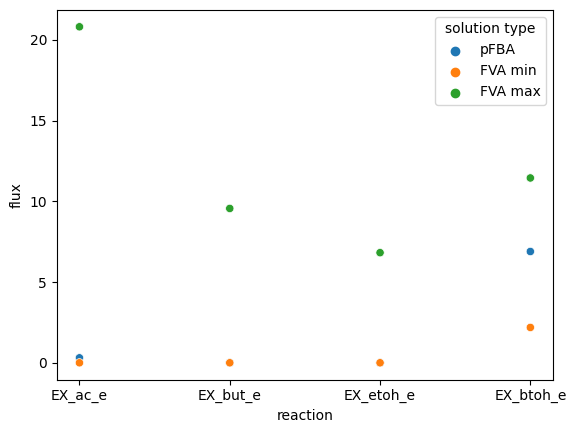

In [5]:
static_sim.plot_production_stats(sol_df)

In [153]:
from cobra.flux_analysis import pfba

with m5:
    m5.medium = medium
    summary = m5.summary()
    sol = m5.optimize()

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [146]:
sol.to_frame().query("abs(fluxes) > 1e-6 and abs(reduced_costs) > 1e-6").sort_values(by="reduced_costs", ascending=False)

,fluxes,reduced_costs
EX_h_e,-10.0,-0.000804
EX_asp__L_e,-0.1,-0.011259
EX_thr__L_e,-0.1,-0.034583
EX_ser__L_e,-0.1,-0.036191
EX_arg__L_e,-0.1,-0.036995
EX_dcyt_e,-0.1,-0.061927
EX_glu__L_e,-0.1,-0.064340
EX_xylan4_e,-1.0,-0.199721
EX_hxan_e,-0.1,-0.223581
EX_xylan8_e,-0.5,-0.399443


In [141]:
summary

Metabolite,Reaction,Flux,C-Number,C-Flux
arg__L_e,EX_arg__L_e,0.1,6,1.04%
asp__L_e,EX_asp__L_e,0.1,4,0.69%
ca2_e,EX_ca2_e,0.001149,0,0.00%
cl_e,EX_cl_e,0.001149,0,0.00%
cobalt2_e,EX_cobalt2_e,2.207E-05,0,0.00%
cu2_e,EX_cu2_e,0.0001565,0,0.00%
cys__L_e,EX_cys__L_e,0.02034,3,0.11%
dcyt_e,EX_dcyt_e,0.1,9,1.56%
fe2_e,EX_fe2_e,0.001482,0,0.00%
fe3_e,EX_fe3_e,0.001723,0,0.00%


In [147]:
import escher
from escher import Builder

builder = Builder(map_json='m5_new_map.json', model=m5, height=600)

In [154]:
builder.reaction_data = sol.fluxes

In [155]:
builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…

In [134]:
# playing around with a few possible added constraints

# added constraint to set a direction
m5.reactions.HACD1i.bounds = (-1000, 0)
m5.reactions.HBCO_nadp.bounds = (0, 1000)
m5.reactions.ALCD2x.bounds = (-1000, 0)
m5.reactions.ALCD2y.bounds = (-1000, 0)
#m5.reactions.IBTMr.bounds = (0, 0)
m5.reactions.ACtr.bounds = (0,0)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

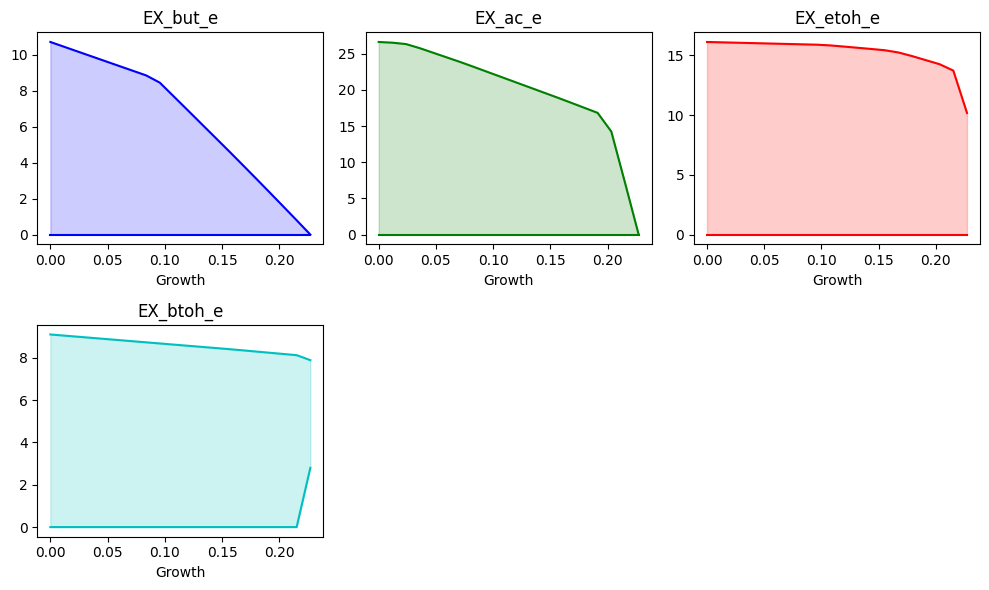

In [156]:
from utils import static_sim

medium = static_sim.get_specific_medium(m5, {"EX_xylan4_e": 1, "EX_xylan8_e": 0.5, "EX_nh4_e": 10, "EX_h_e": 10})

prod_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e"]

static_sim.plot_flux_envelopes(m5, medium=medium, reactions=prod_reactions)

## enforce xylose secretion

In [7]:
from cobra.flux_analysis import pfba

with m5:
    m5.medium = medium
    
    #m5.reactions.EX_xyl__D_e.bounds = (1, 1000)
    m5.reactions.XYLANabc.bounds = (0, 0)
    m5.reactions.XYLt2.bounds = (0, 4)
    m5.reactions.XYLabc.bounds = (0, 0)
    m5.reactions.XYLtex.bounds = (0, 0)

    summary = m5.summary()
    pfba_solution = pfba(m5)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [8]:
import escher
from escher import Builder

builder = Builder(map_json='substrate_uptake_map.json', model=m5, height=600)
builder.reaction_data = pfba_solution.fluxes
builder

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR141tipp': 0.0, '12DGR160tip…

## Dynamic sim.

In [9]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

m5_med = media_db[media_db["medium"] == "m5_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in m5_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}

# TODO: calculate xylan (60 g/L concentration) to an amount of moles that makes sense
#added_metabilotes["xylan4_e"] = 10
added_metabilotes["xylan8_e"] = 2.5
added_metabilotes["xylan4_e"] = 5

In [10]:
# arbitrary values rn - trying to get the model to produce extracelullar xylose

m5.reactions.EX_xyl__D_e.bounds = (1, 1000)
m5.reactions.XYLANabc.bounds = (0, 0)
m5.reactions.XYLt2.bounds = (0, 4)
m5.reactions.XYLabc.bounds = (0, 0)
m5.reactions.XYLtex.bounds = (0, 0)

In [11]:
from utils.comets_functions import single_strain

sim = single_strain(model=m5, medium=added_metabilotes, sim_time=40)


Running COMETS simulation ...
Done!


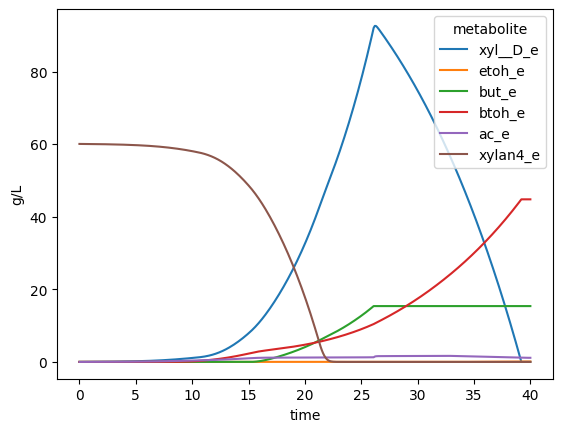

In [12]:
import seaborn as sns
from utils.comets_functions import plot_metabolites, plot_biomass, plot_reaction_flux

metabolites = ["xyl__D_e", "etoh_e", "but_e", "btoh_e", "ac_e", "xylan4_e"]

plot_metabolites(sim, metabolites)

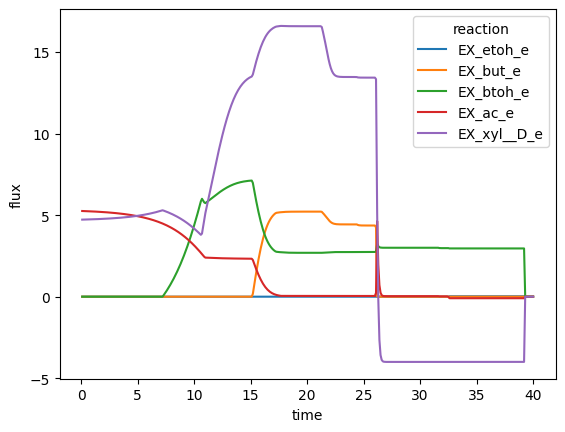

In [63]:
production_reactions = ["EX_etoh_e", "EX_but_e", "EX_btoh_e", "EX_ac_e", "EX_xyl__D_e"]

plot_reaction_flux(sim, production_reactions, "M5")

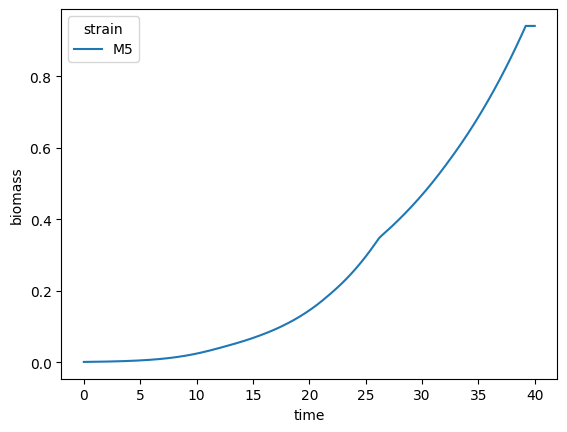

In [64]:
plot_biomass(sim)

In [71]:
from escher import Builder

animation = Builder(map_json='substrate_uptake_map.json', model=m5, height=600)

In [73]:
from time import sleep
from tqdm.notebook import tqdm

fluxes = sim.fluxes_by_species["M5"].drop(columns=["x", "y"])
melted_fluxes = fluxes.melt(id_vars="cycle", value_name="flux", var_name="reaction")

n_cycles = fluxes.shape[0]

for i in tqdm(range(n_cycles)):
    point_in_time = melted_fluxes[melted_fluxes["cycle"] == i]
    flux_series = point_in_time.set_index("reaction")["flux"]
    animation.reaction_data = flux_series
    sleep(0.1)

  0%|          | 0/400 [00:00<?, ?it/s]

In [72]:
animation

Builder(height=600)